# 🪖⚒️Construction Site Safety: A Beginner's EDA 🔎

**This is my first public notebook, I have tried to include everything I have learned so far. Please do let me know about any improvements I need to make at my end :D**

There have been many incidents of accidents on construction site, where workers succumbed to various intensities of injuries and even fatalities. Some common injuries include: 
- Burns 
- Scrapes
- Amputations
- Hearing loss 
- Head injuries 

and so on. Most of these injuries are caused due to improper guidance and lack of appropriate Personal Protective Equipment (PPE) kits.

Construction site managers and even some workers dont take these setbacks and incidents seriously thus making the construction site dangerous for others. In this notebook, we will try to assess a dataset on Construction Site Safety Image Dataset uploaded by Roboflow. The dataset can be accessed here: [**Construction Site Safety Image Dataset**](https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety)

We will first do an exploratory data analysis on the CSS Dataset and try to see the distribution of `train`, `valid` and `test` sets. We will also visualize the samples, and run a custom object detection model to detect one of the following PPE classes: 

**['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']** using YoloV8.

**`Note`** This is an introductory notebook, I have tried to include my learnings in a beginner-friendly manner.

# Import Libraries

We will import the following libraries for EDA and visualizations. 
- `os` and `glob` for accessing file directories 
- `numpy` for array operations
- `pandas` for dataframes, metadata creation
- `PIL` and `cv2` for Image oparations and visualization
- `matplotlib` for plotting results and class distributions

In [1]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 🔑🔑 Key Tip 

Always start by mentioning the input and output path names, for future reference, access and usage. Input path names include all those paths, which are required for providing input to your ML model. Output path is where you save all your intermediate or final results.
Some outputs that you might save after training a model are :
- `csv` file which mentions the results, or predictions
- `model` file in `.h5`, `.ckpt`, '.pt` format
- `image` file in `.jpg` or `.png` format

Kaggle allows you to save around 19.5 GB of output files, after running your notebook. It also lets you save a working instance of the notebook via `Quick Save` which stores all the output directory contents.

**Yet another tip:** Try to maintain **uniformity** in naming variables. For instance, if you have mentioned the validation set path as `valid_path` make sure you use `valid` more than shortcuts `val` throughout as it reduces scope of errors.

In [2]:
# Data path
data_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow'
# Train, Valid and Test path
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test')
# For saving results
output_path = '/kaggle/working'
# We can access both images and labels
folders = ['images', 'labels']
print("Data Path: {}\nTrain Path: {}\nValid Path: {}\nTest Path: {}\nOutput Path: {}".format(data_path, train_path, valid_path, test_path, output_path))

Data Path: /kaggle/input/construction-site-safety-image-dataset-roboflow
Train Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/train
Valid Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/valid
Test Path: /kaggle/input/construction-site-safety-image-dataset-roboflow/test
Output Path: /kaggle/working


# 📅 ℹ️ Metadata
Metadata literally means data about data. We will create metadata (`csv` file) which contains all the information about the file directory and the split information (which file is train, valid or test). We will not include raw image information as it will make the csv file very heavy and it is unncessary.

Later only through this metadata we can make sure whether a file is in the train, valid or test set and what are the annotations for the file. It is also very helpful in visualizing results. In scenarios, where dataset is not provided, heavy metadata files are provided (multiple CSV files) which is easier if you are dealing with say 1 million images. 


In [3]:
# Initialize dictionaries of training and classes
train_dict = dict(train=0, valid=1, test=2)
path_dict = [train_path, valid_path, test_path]
class_names = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
class_dict = dict(zip(range(len(class_names)), class_names))
print(class_dict)

{0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}


In [4]:
## Get filenames and labels information
# Sorting the filenames will make the labels and images in same order 
train_filenames = sorted(os.listdir(os.path.join(train_path, folders[0])))
valid_filenames = sorted(os.listdir(os.path.join(valid_path, folders[0])))
test_filenames = sorted(os.listdir(os.path.join(test_path, folders[0])))
train_labels = sorted(os.listdir(os.path.join(train_path, folders[1])))
valid_labels = sorted(os.listdir(os.path.join(valid_path, folders[1])))
test_labels = sorted(os.listdir(os.path.join(test_path, folders[1])))

In [5]:
## One liner for the above code
# We can also use list comprehension for this
t_f, v_f, te_f = [sorted(os.listdir(os.path.join(path_dict[i], folders[0]))) for i in range(len(path_dict))]
t_l, v_l, te_l = [sorted(os.listdir(os.path.join(path_dict[i], folders[1]))) for i in range(len(path_dict))]

In [6]:
# Check whether both gives same results in filenames
train_filenames==t_f, valid_filenames==v_f, test_filenames==te_f

(True, True, True)

In [7]:
# Check whether both gives same results in labels
train_labels==t_l, valid_labels==v_l, test_labels==te_l

(True, True, True)

## ⬜ Check these things
1. Length of **training/validation/test filenames** are same as **training/validation/test labels**

2. Order of **training/validation/test filenames** are same as **training/validation/test labels**

3. Leakage of files and duplicate entries in **training/validation/test filenames**

### ✅ Check lengths

In [8]:
# Return lengths of all filenames
print("Total Train Files: {}\nTotal Valid Files: {}\nTotal Test Files:{}".format(len(train_filenames), len(valid_filenames), len(test_filenames)))

Total Train Files: 2605
Total Valid Files: 114
Total Test Files:82


In [9]:
# Check whether filenames and labels are of same length
len(train_filenames)==len(train_labels), len(valid_filenames)==len(valid_labels), len(test_filenames)==len(test_labels)

(True, True, True)

### ✅ Check Order
We will check the order of filenames and labels to make sure that each image has the same label annotation name as that of the image. This will ensure that we are not using annotations and label information for a different image.

In [10]:
# Check order in filenames and labels in all splits
[item.split('.')[0] for item in train_filenames]==[item.split('.')[0] for item in train_labels],\
[item.split('.')[0] for item in valid_filenames]==[item.split('.')[0] for item in valid_labels],\
[item.split('.')[0] for item in test_filenames]==[item.split('.')[0] for item in test_labels]

(True, True, True)

### ✅ Check Leakage
We will check whether any filename is present in more than one set. This is known as leakage in datasets. If some filenames are common in more than one set say training or validation, then the training will not be dependable. 

Manytimes, large datasets from different competitions have manual annotators. We should always check these three things before proceeding with EDA or pre-processing.

In [11]:
set(train_filenames).intersection(set(valid_filenames)),\
set(valid_filenames).intersection(set(test_filenames)),\
set(test_filenames).intersection(set(train_filenames))

(set(), set(), set())

In [12]:
df = pd.DataFrame()
df['filenames'] = train_filenames + valid_filenames + test_filenames
df['labelnames'] = train_labels + valid_labels + test_labels
df['train_id'] = [0]*len(train_filenames) + [1]*len(valid_filenames) + [2]*len(test_filenames)

In [13]:
df.head()

filenames  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...   

                                          labelnames  train_id  
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...         0  
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...         0  
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...         0  
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...         0  
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...         0

### ✅ Check Duplicate Entries

In [14]:
# No duplicate entries found
df.filenames.duplicated().value_counts()

False    2801
Name: filenames, dtype: int64

In [15]:
# Count of train valid and test sets
df.train_id.value_counts()

0    2605
1     114
2      82
Name: train_id, dtype: int64

<AxesSubplot:title={'center':'Train-Val-Test Split'}>

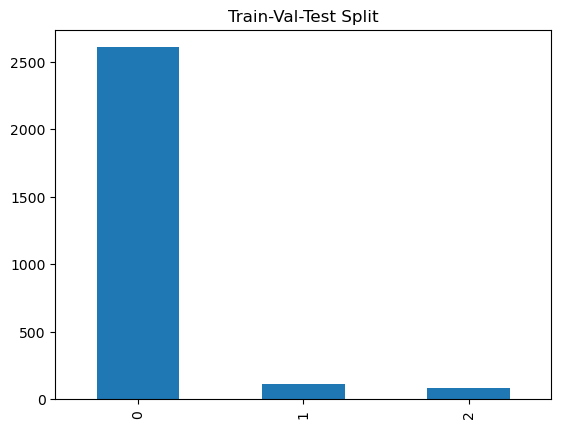

In [16]:
df.train_id.value_counts().plot(kind = 'bar', title = 'Train-Val-Test Split')

## Visualize Class Distribution
In this dataset, each image consists of more than 1 class annotation in general. So we need to check the total number of annotations in each image only then we can visualize an overall class distribution.

There are three cases when we read the annotation file. 

**1. Annotation file is empty.**

`len(annotation)===0`
We will skip these files during training and evaluation of our object detection model.

**2. Annotation file is having only one annotation.** 

`len(annotation.shape)==1`
We will reshape the array and get the annotations.

**3. Annotation file is having multiple annotations.** 

`len(annotation)>1`
We will get the annotations direclty.

In [17]:
# Split list
train_keys = list(train_dict.keys())

In [18]:
# Complete path for annotation_files
annotation_files = (data_path + '/' + df.train_id.map(lambda x: train_keys[x]) + '/' + folders[1]
                    + '/' + df.labelnames).tolist()
t_id = df.train_id.tolist()
counts = []
invalid_idx = []
is_annotated = []
for idx, annotation_file in tqdm.tqdm(enumerate(annotation_files)):
    annotation = np.loadtxt(annotation_file)
    if len(annotation)==0:
        invalid_idx.append(idx)
        is_annotated.append(-1)
        counts.append([])
        continue
    if len(annotation.shape)==1:
        annotation = annotation.reshape(1, -1)
    counts.append(annotation[:,0].astype(int))
    is_annotated.append(1)
df['is_annotated'] = is_annotated

2801it [00:23, 118.55it/s]


In [19]:
df.is_annotated.value_counts()

 1    2777
-1      24
Name: is_annotated, dtype: int64

In [20]:
# Create a count_dict which holds class counts per split (train/valid/test)
count_list = [np.unique(item, return_counts = True) for item in counts]
count_keys = [item[0] for item in count_list]
count_values = [item[1] for item in count_list]
count_dict = []
for ck,cv in zip(count_keys, count_values):
    count_dict.append(dict([(key,value) for key, value in zip(ck,cv)]))
df['count_dict'] = count_dict

In [21]:
from collections import Counter
train_count = df[df.train_id==0].count_dict.apply(lambda x: Counter(x)).sum()
valid_count = df[df.train_id==1].count_dict.apply(lambda x: Counter(x)).sum()
test_count = df[df.train_id==2].count_dict.apply(lambda x: Counter(x)).sum()

In [22]:
# We will normalize the counts to get a correct visualization, since there is huge difference
# between the counts of train valid and test splits
train_count = {key:value/sum(train_count.values()) for key, value in train_count.items()}
valid_count = {key:value/sum(valid_count.values()) for key, value in valid_count.items()}
test_count = {key:value/sum(test_count.values()) for key, value in test_count.items()}

In [23]:
print("Train Class Distribution Dict: {}\n\nValid Class Distribution Dict: {}\n\nTest Class Distribution Dict: {}"
     .format(train_count, valid_count, test_count))

Train Class Distribution Dict: {0: 0.08524190269684238, 1: 0.04474861092288928, 2: 0.06279983737633826, 3: 0.08394091340290012, 5: 0.2583547906220355, 4: 0.10738582463748475, 7: 0.0822062610109771, 8: 0.14221439219406423, 6: 0.09123187423770159, 9: 0.04187559289876677}

Valid Class Distribution Dict: {0: 0.1133428981348637, 3: 0.10616929698708752, 4: 0.15208034433285508, 5: 0.2381635581061693, 7: 0.058823529411764705, 2: 0.09899569583931134, 1: 0.03012912482065997, 6: 0.06312769010043041, 8: 0.07890961262553801, 9: 0.06025824964131994}

Test Class Distribution Dict: {0: 0.14473684210526316, 3: 0.10394736842105264, 4: 0.11842105263157894, 5: 0.22894736842105262, 6: 0.12105263157894737, 9: 0.05394736842105263, 2: 0.05394736842105263, 7: 0.08026315789473684, 8: 0.05789473684210526, 1: 0.03684210526315789}


In [24]:
df_count = pd.DataFrame()
df_count = pd.DataFrame({'train':train_count, 'valid': valid_count, 'test': test_count}).sort_index()

In [25]:
df_count['idx'] = pd.Series(df_count.index)

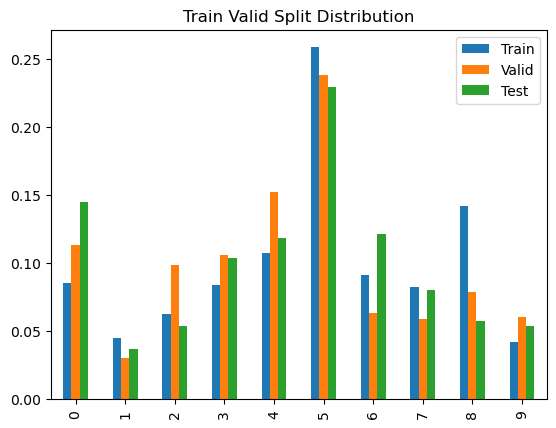

In [26]:
df_count.plot(y = ['train', 'valid', 'test'], kind = 'bar', title = 'Train Valid Split Distribution')
plt.legend(['Train', 'Valid', 'Test'])

We can see the normalized counts of all the classes are more or less balanced, this will ensure that we are not seeing some classes more oftenly than others during training as the distribution is almost same in all classes (among all splits).

# Visualize Samples
Let us visualize some samples from the dataset and their annotations. Since we have all the annotations in YoloV8 format we will start with converting these annotation files to bounding box coordinates.

YoloV8 format for annotation has 5 entries in each line of the txt file. 
- Class Label (c)
- Bounding Box's center (X coordinate)
- Bounding Box's center (Y coordinate)
- Width of Bounding Box (w)
- Height of Bounding Box (h)

The bounding box can be calculated from the last 4 entries in the annotation file.

In [27]:
def yolo_annotation_to_bbox(annotation, img_height, img_width):
    """
    Converts Yolo annotations to bounding box coordinates
    Input:
    annotation: str, annotation file in .txt format
    img_height: int, image height
    img_width: int, image width
    Output:
    class: list, List of labels in the image
    bbox_list: list, List of bounding boxes in an image
    """
    sh = annotation.shape
    if len(sh)==0:
        print("No bounding box found")
    if len(sh)==1:
        annotation = annotation.reshape(1, -1)
    num_bbox = len(annotation)
    bbox_list = []
    for idx in range(num_bbox):
        c_x, c_y, w, h = annotation[idx][1:]
        x1 = ((c_x - w/2)*img_width).astype(int)
        x2 = ((c_x + w/2)*img_width).astype(int)
        y1 = ((c_y - h/2)*img_height).astype(int)
        y2 = ((c_y + h/2)*img_height).astype(int)
        bbox_list.append([x1, y1, x2, y2])
    return bbox_list

In [28]:
### invalid_files = (data_path + '/' + df.train_id[invalid_idx].apply(lambda x: train_keys[x]) + '/' + folders[0] + '/' + df.filenames[invalid_idx])
invalid_files = df.filenames[invalid_idx]
def visualize_samples(mode = 'train', n_samples = 12):
    """
    Plots 'n_samples' plots from train/valid/test split
    Input:
    mode: 'str' can take values from 'train'/'valid','test'
    n_samples: 'int'
    """
    # We will visualize only those files which have annotations 
    indices = df[(~df.filenames.isin(invalid_files))&(df.train_id==1)].sample(n_samples).index
    filenames = (data_path + '/' + df.train_id[indices].apply(lambda x: train_keys[x]) + '/' + folders[0] + '/' + df.filenames[indices]).tolist()
    annotations = (data_path + '/' + df.train_id[indices].apply(lambda x: train_keys[x]) + '/' + folders[1] + '/' + df.labelnames[indices]).tolist()
    plt.figure(figsize = (21, 11))
    plt.title('{} Set Samples'.format(mode.upper()))
    for idx in range(len(filenames)):
        image = np.array(Image.open(filenames[idx]))
        height, width, _ = image.shape 
        annotation = np.loadtxt(annotations[idx])
        bbox_list = yolo_annotation_to_bbox(annotation, height, width)
        if len(annotation.shape)==1:
            annotation = annotation.reshape(1, -1)
        labels = [class_dict[item] for item in annotation[:,0].astype(int)]
        plt.subplot(3, 4, idx + 1)
        for label, bbox in zip(labels, bbox_list):
            x1, y1, x2, y2 = bbox
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

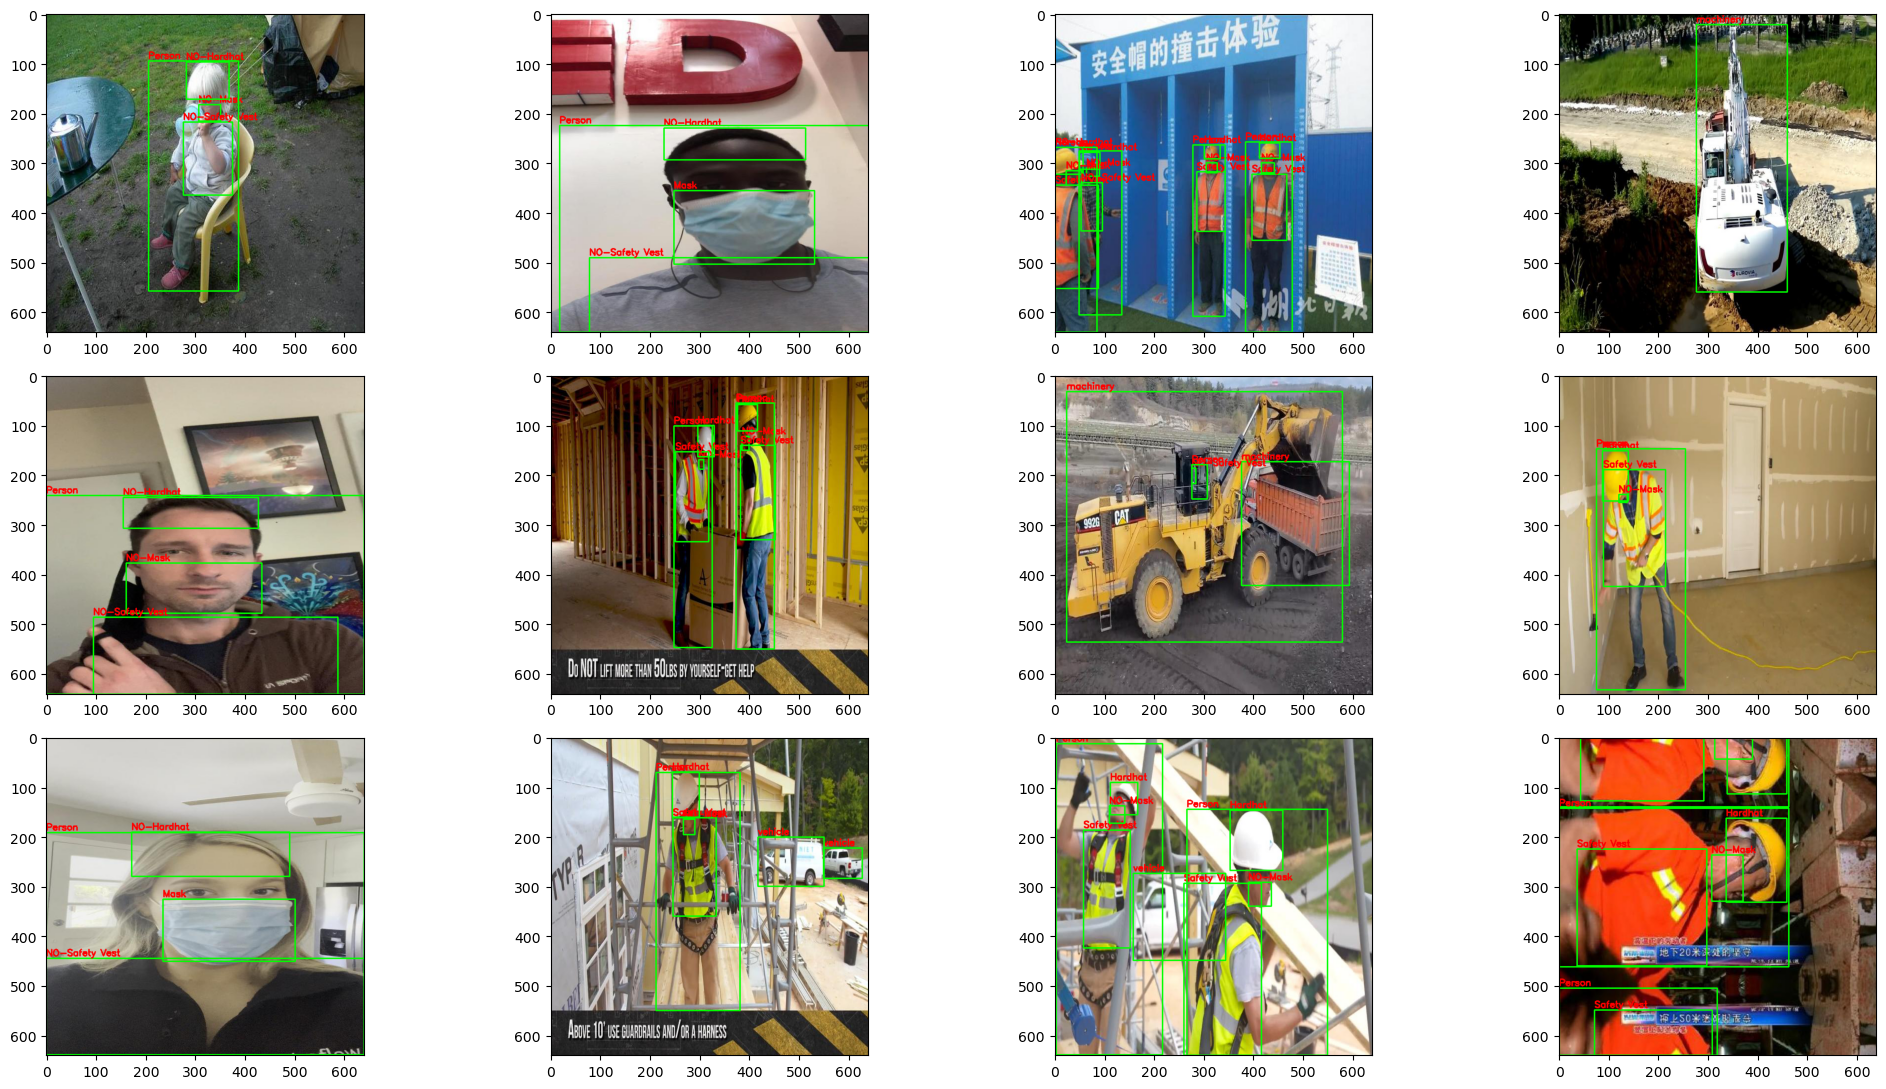

In [29]:
visualize_samples(mode = 'train', n_samples = 12)

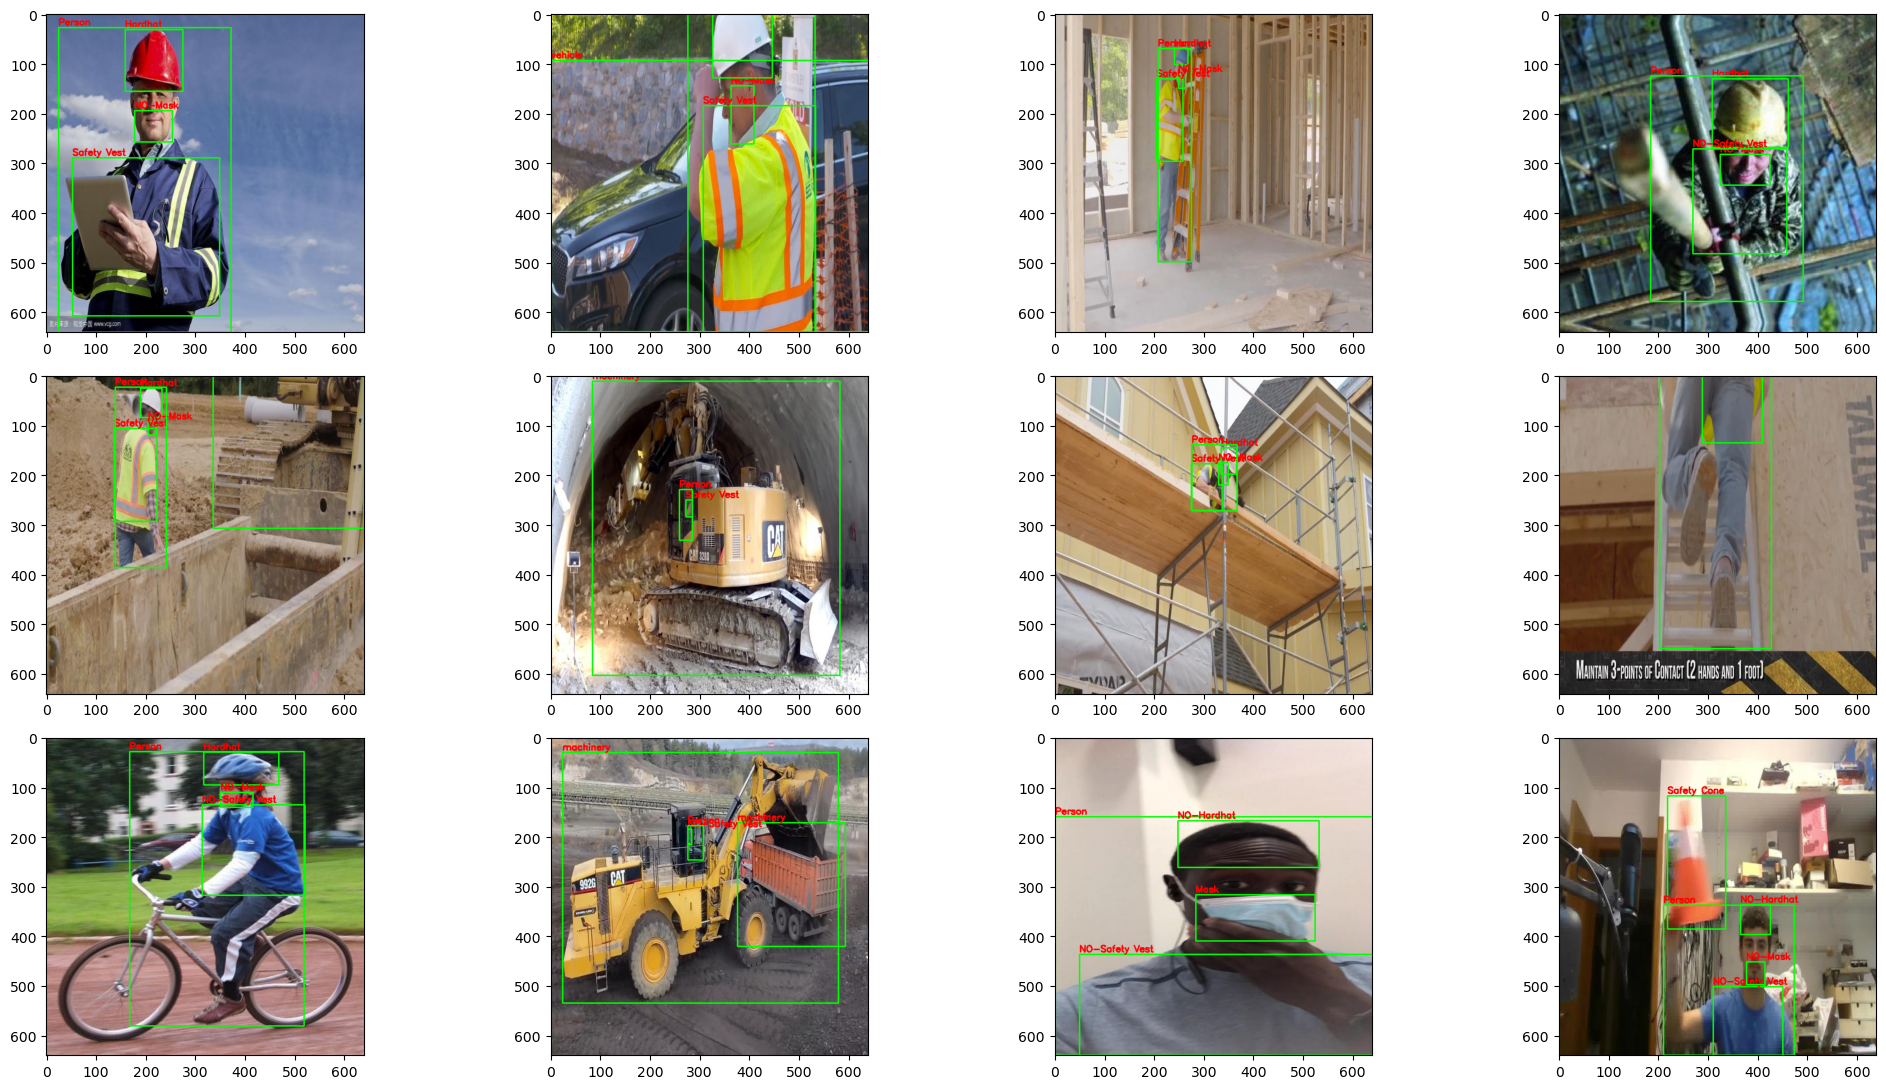

In [30]:
visualize_samples(mode = 'valid', n_samples = 12)

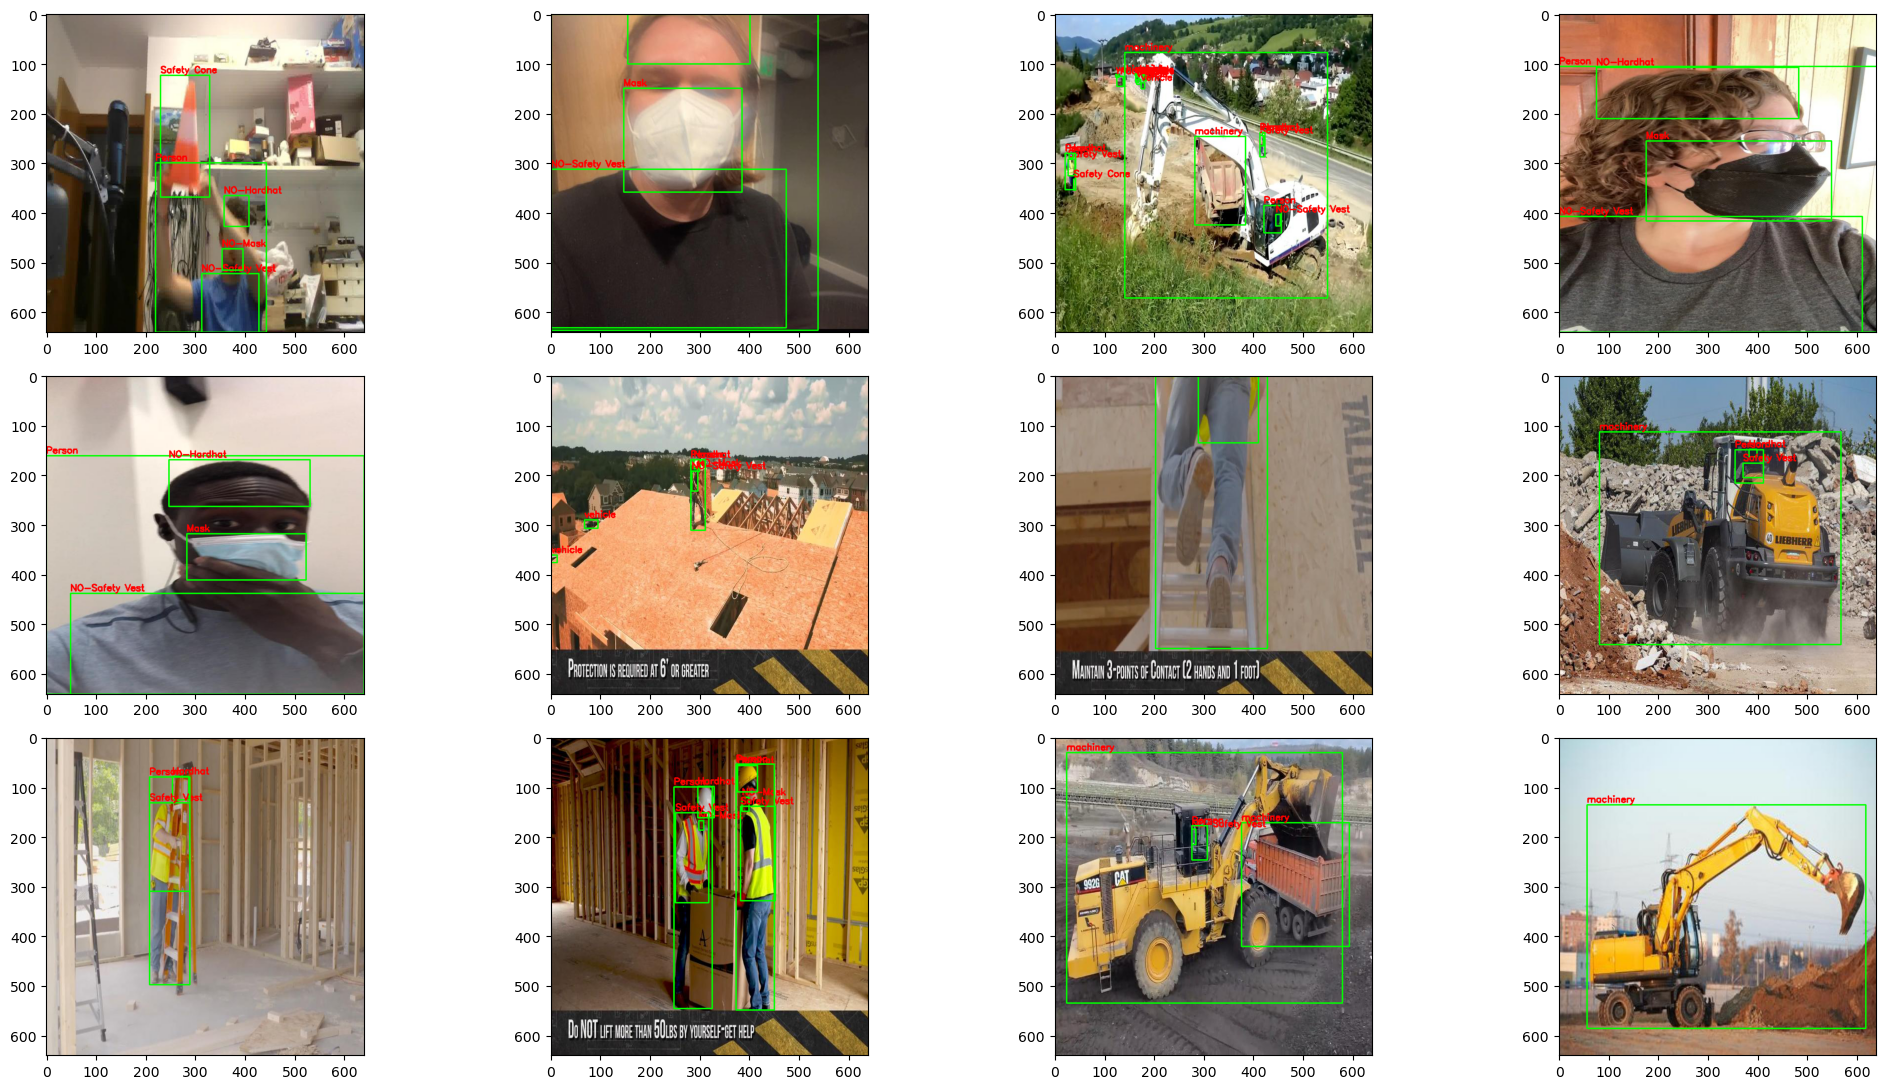

In [31]:
visualize_samples(mode = 'test', n_samples = 12)

# 🧑‍💻 👓Run Custom Object Detection Model
After the visualization of dataset it is time to train our custom object detection. We will use YoloV8 to train our custom object detection model. More information on YoloV8 here: [**Ultralytics Docs**](https://docs.ultralytics.com)

## Install Ultralytics

In [32]:
!pip install -q ultralytics

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.10.1 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.61.0 which is incompatible.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-serving-api 2.10.0 requires tensorflow<3,>=2.10.0, but you have tensorflow 2.9.2 which is incompatible.
ortools 9.5.2237 requires protobuf>=4.21.5, but you have protobuf 3.19.6 which is incompatible.
onnx 1.13.0 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
nnabla 1.34.0 requires protobuf<=3.19.4; platform_system != "Windows", but you have protobuf 3.19.6 wh

## Create YAML file

We will create a YAML file which will be used by the YoloV8 CLI for information. It mentions the `train`, `valid`, `test` directories and the `nc` (number of classes) for training the model

In [33]:
import yaml
ppe_data = dict(train = train_path,
                    val = valid_path,
                    test = test_path,
                   nc = len(class_names),
                   names = class_names)
with open('ppe_data.yaml', 'w') as output:
    yaml.dump(ppe_data, output, default_flow_style = True)

In [34]:
%cat /kaggle/working/ppe_data.yaml

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
{names: [Hardhat, Mask, NO-Hardhat, NO-Mask, NO-Safety Vest, Person, Safety Cone,
    Safety Vest, machinery, vehicle], nc: 10, test: /kaggle/input/construction-site-safety-image-dataset-roboflow/test,
  train: /kaggle/input/construction-site-safety-image-dataset-roboflow/train, val: /kaggle/input/construction-site-safety-image-dataset-roboflow/valid}


## Train a custom model

We will use the Command Line Interface (CLI) command for training a custom model using YoloV8. The arguments provided depends on our tasks and training. We will train the model for 250 epochs on a pre-trained model (on COCO128 data) for our PPE Detection dataset.

In [35]:
!yolo task=detect mode=train epochs=100 data='/kaggle/working/ppe_data.yaml' model=yolov8n.pt imgsz=640 patience=10

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|██████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 7.39MB/s]
Ultralytics YOLOv8.0.43 🚀 Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/ppe_data.yaml, epochs=100, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/100      12.7G      1.235      1.529      1.358        356        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.623      0.459      0.511      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/100      12.7G      1.223      1.516      1.364        268        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.663      0.473      0.536      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/100      12.7G      1.202      1.473      1.342        441        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.668      0.534      0.587      0.292

      Epo


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/100      12.7G      1.023      1.013      1.212        248        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697        0.8      0.645      0.705      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/100      12.7G      1.007     0.9995      1.209        261        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.828      0.634      0.711      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/100      12.7G      1.007     0.9845        1.2        184        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.874      0.604        0.7      0.384

      Epo


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/100      12.7G     0.9111      0.831      1.143        195        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.858      0.691      0.758      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/100      12.7G     0.9052     0.8235      1.135        313        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.862      0.692      0.758      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/100      12.7G     0.9037     0.8254       1.14        284        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.876      0.701      0.771      0.453

      Epo


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/100      12.7G     0.8234     0.7097      1.088        258        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.897      0.717      0.799       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/100      12.7G       0.82     0.7062      1.085        241        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.897      0.726      0.798      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     84/100      12.7G     0.8225     0.7109      1.088        234        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        114        697      0.889      0.722      0.803      0.495

      Epo

In [ ]:
!zip -r results_yolov8n_100e.zip /kaggle/working

# 📈📊Visualize Results

In [ ]:
train_results_path = '/kaggle/working/runs/detect/train/'
csv_results = train_results_path + 'results.csv'
image_results = train_results_path + '*.*'
df_results = pd.read_csv(csv_results)
df_results.head()

In [ ]:
plt.figure(figsize = (21, 11))
for result in glob.glob(image_results):
    ext = result.split('/')[-1].split('.')[-1]
    if (ext=='jpg')or(ext=='jpeg')or(ext=='png'):
        image = PIL.Image.open(result)
        image = np.array(image)
        plt.imshow(image)
        plt.title('{}'.format(result.split('/')[-1].split('.')[0]))
    plt.show()

# 🔮Prediction

In [ ]:
best_model = train_results_path + 'best.pt'
test_results_path = '/kaggle/working/runs/detect/predict'
test_result_filenames = glob.glob(test_results_path + '/*.*')
model = YOLO(best_model)
results = model.predict(source= test_results_path, save = True, show=True, save_txt = True) 
for filename in test_result_filenames:
    results = model.predict(source = filename, save = True, show = True, save_txt = True)

In [ ]:
!yolo task=detect mode=predict model='/kaggle/working/runs/detect/train/weights/best.pt' source='/kaggle/input/weapon-detection-test/weapon_detection/test/test/' save=True